In [124]:
!pip install tensorflow_model_optimization

In [125]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import requests


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

On telecharge et dezip le fichier qui contient notre dataset

In [126]:
import pathlib
import os
data_dir = tf.keras.utils.get_file(
    "dataset.zip",
    "https://github.com/Rianesmili/projet-detection-panneau-tf/blob/main/Paneau/dataset.zip?raw=true",
    extract=False)

data_test_dir = tf.keras.utils.get_file(
    "test_data.zip",
    "https://github.com/Rianesmili/projet-detection-panneau-tf/blob/main/Paneau/test_data.zip?raw=true",
    extract=False)

import zipfile
with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets')

with zipfile.ZipFile(data_test_dir, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets/test')

data_dir = pathlib.Path('/content/datasets/dataset')
data_validation_dir = pathlib.Path('/content/datasets/test')

print(data_dir)
print(os.path.abspath(data_dir))

/content/datasets/dataset
/content/datasets/dataset


Shape of the image (43247,)


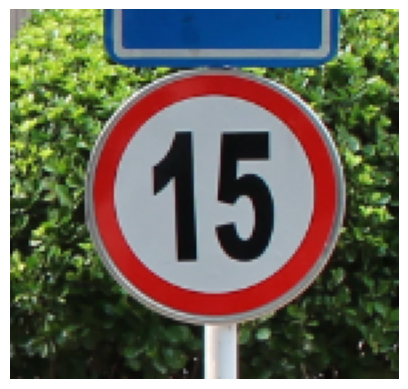

Shape of the image (39895,)


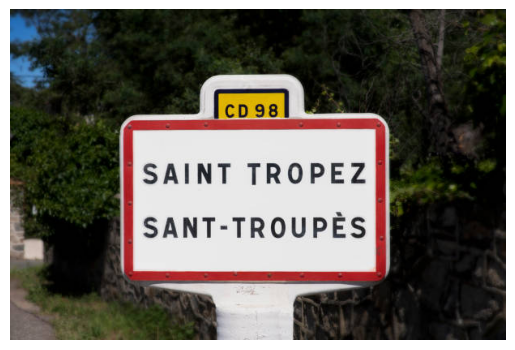

In [127]:
url_code = r'https://github.com/Rianesmili/projet-detection-panneau-tf/blob/main/Paneau/paneau_du_code_de_la_route.png?raw=true'
resp = requests.get(url_code, stream=True).raw
image_array_code = np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_code.shape}')
image_code = cv2.imdecode(image_array_code, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_code, cv2.COLOR_BGR2RGB))
plt.show()

url_ville = r'https://github.com/Rianesmili/projet-detection-panneau-tf/blob/main/Paneau/paneau_de_ville.jpg?raw=true'
resp = requests.get(url_ville, stream=True).raw
image_array_ville = np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_ville.shape}')
image_ville = cv2.imdecode(image_array_ville, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_ville, cv2.COLOR_BGR2RGB))
plt.show()

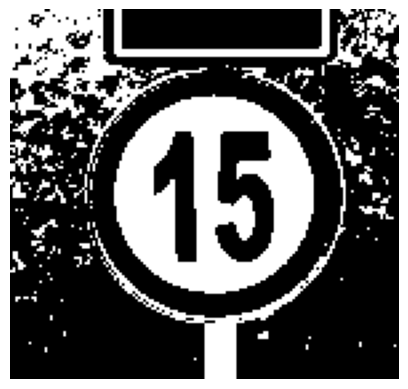

In [128]:
#Convert to bw
img_bw = cv2.imdecode(image_array_code, cv2.IMREAD_GRAYSCALE)
(thresh, img_bw) = cv2.threshold(img_bw, 127, 255, cv2.THRESH_BINARY)
plt.axis('off')
plt.imshow(cv2.cvtColor(img_bw, cv2.COLOR_BGR2RGB))

[[-10   0  10]
 [-10   0  10]
 [-10   0  10]]


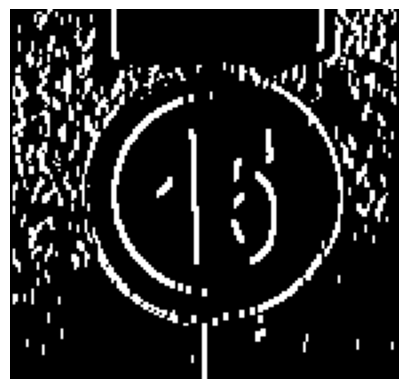

In [129]:
#defining a vertical edge detection kernel
kernel = np.matrix([[-10,0,10],[-10,0,10],[-10,0,10]])
print(kernel)
img_1 = cv2.filter2D(img_bw, -1, kernel)
plt.axis('off')
plt.imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))

[[ 10  10  10]
 [  0   0   0]
 [-10 -10 -10]]


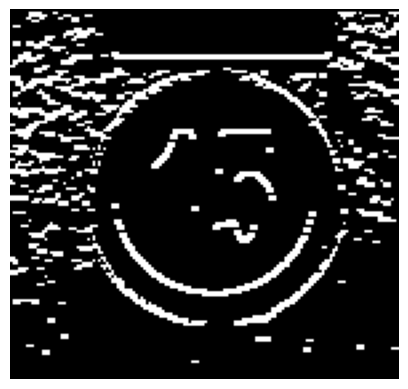

In [130]:
#defining an horizontal edge detection kernel
kernel = np.matrix([[10,10,10],[0,0,0],[-10,-10,-10]])
print(kernel)
img_1 = cv2.filter2D(img_bw, -1, kernel)
plt.axis('off')
plt.imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))

In [131]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

1904


In [132]:
image_count = len(list(data_validation_dir.glob('*/*')))
print(image_count)

1


### Create a dataset

On vas utiliser une fonction keras pour pre processer le jeu de deonnée pour les mettre dans la meme taailel et de les grouper pour les envoyer en groupe via un btach

batch_size = 32 img_height = 200 img_width = 200

In [133]:
batch_size = 32
img_height = 200
img_width = 200

In [134]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1904 files belonging to 3 classes.
Using 1524 files for training.


Dans ce code il ne permet que chaque classe correspond a un folder du meme nom

Construire le jeux validation


In [135]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_validation_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4752 files belonging to 1 classes.
Using 950 files for validation.


In [136]:
class_names = train_ds.class_names
print(class_names)

['panneau_code_de_la_route', 'panneau_danger', 'panneau_de_ville']


## Visualize the data


Un echantillion correspandant au batch size on a batch size = 4 on vas avoir quatres images

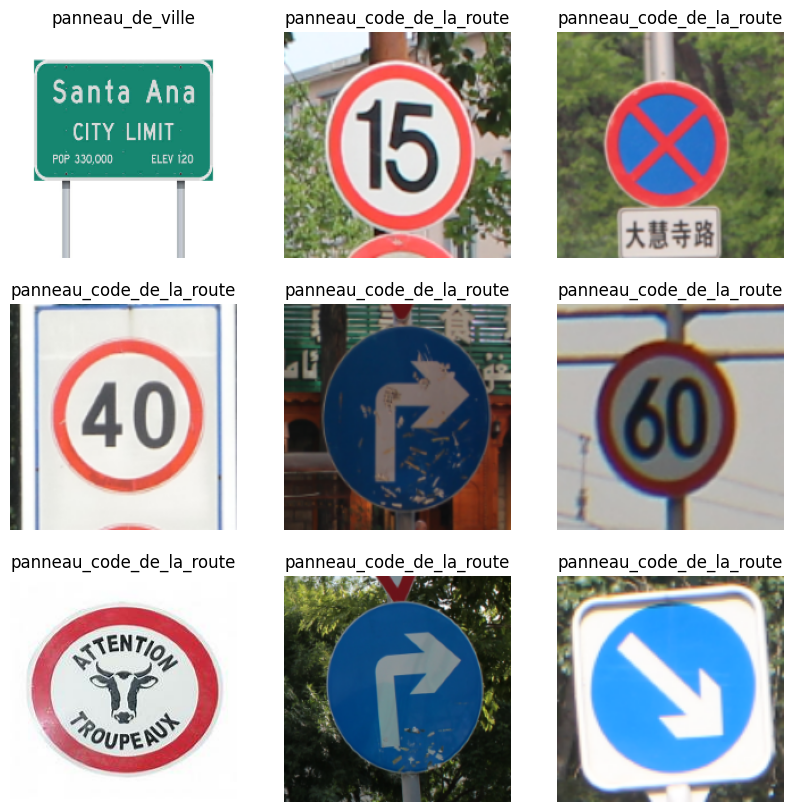

In [137]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [138]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 200, 200, 3)
(32,)


In [139]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

Les valeurs des canaux RVB se situent dans la plage [0, 255]. Ce n'est pas idéal pour un réseau neuronal ; en général, vous devriez chercher à rendre vos valeurs d'entrée petites.

standardiser les valeurs pour qu'elles se situent dans la plage [0, 1] en utilisant tf.keras.layers.Rescaling

In [140]:
normalization_layer = layers.Rescaling(1./255)

In [141]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0670044 0.97615653


## Keras model

In [142]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.Conv2D(16,4, activation='relu'),
  #layers.MaxPooling2D(), #max pooling prend le maximum a chaque fois il exsite d'autres qui prennent la moyenne avrege
  #ces couches seront une suite de convolution et de poolig aui seront de plus en plus petit
  #layers.Conv2D(8,4, activation='relu'),
  #layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

In [143]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

In [144]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 100, 100, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 50, 50, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 50, 50, 64)      

### Train the model

In [145]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
48/48 [==============================] - 6s 90ms/step - loss: 0.3594 - accuracy: 0.9173 - val_loss: 0.0480 - val_accuracy: 0.9874
Epoch 2/10
48/48 [==============================] - 2s 46ms/step - loss: 0.0274 - accuracy: 0.9934 - val_loss: 0.0181 - val_accuracy: 0.9958
Epoch 3/10
48/48 [==============================] - 2s 36ms/step - loss: 0.0108 - accuracy: 0.9967 - val_loss: 0.0197 - val_accuracy: 0.9958
Epoch 4/10
48/48 [==============================] - 2s 33ms/step - loss: 0.0326 - accuracy: 0.9902 - val_loss: 2.6205e-04 - val_accuracy: 1.0000
Epoch 5/10
48/48 [==============================] - 2s 36ms/step - loss: 0.0110 - accuracy: 0.9967 - val_loss: 0.0022 - val_accuracy: 0.9989
Epoch 6/10
48/48 [==============================] - 2s 35ms/step - loss: 0.0019 - accuracy: 0.9993 - val_loss: 0.0064 - val_accuracy: 0.9979
Epoch 7/10
48/48 [==============================] - 2s 39ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0124 - val_accuracy: 0.9968
Epoch 8/1

## Visualize training results

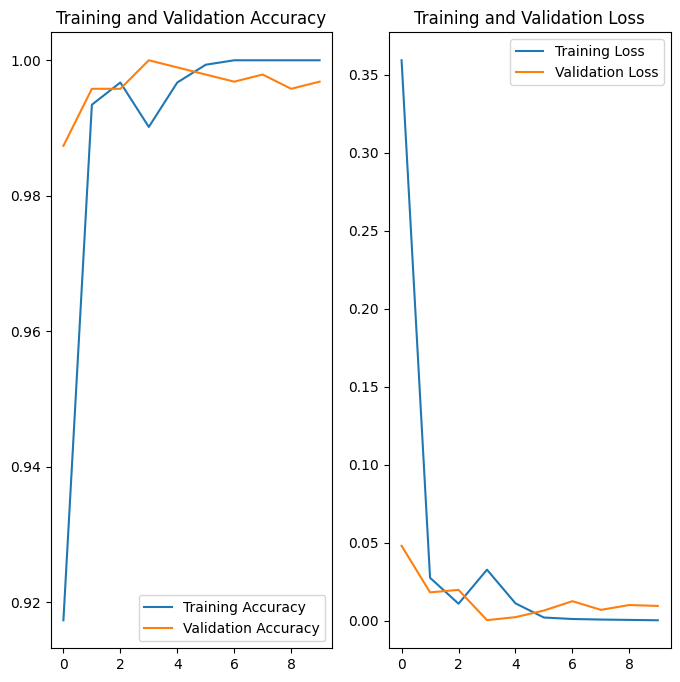

In [146]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

 Data augmentation

Le surapprentissage se produit généralement lorsqu'il y a un petit nombre d'exemples d'entraînement. L'augmentation des données consiste à générer des données d'entraînement supplémentaires à partir de vos exemples existants en les augmentant à l'aide de transformations aléatoires qui produisent des images d'apparence crédible. Cela permet d'exposer le modèle à davantage d'aspects des données et de mieux généraliser.

In [147]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

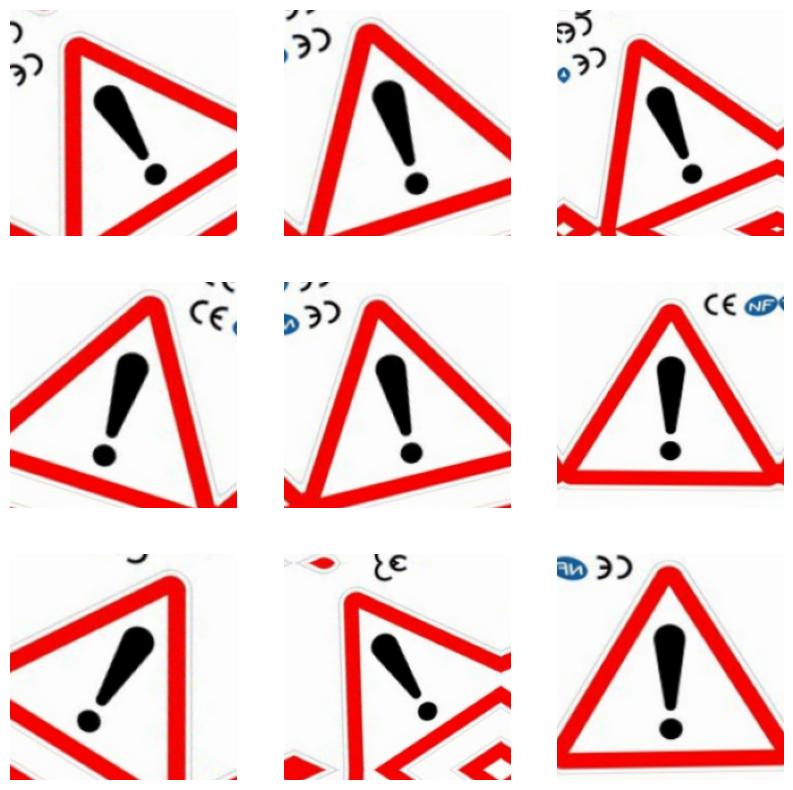

In [148]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [149]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [150]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [151]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 200, 200, 3)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 100, 100, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 50, 50, 32)        0         
 ng2D)                                               

In [152]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
48/48 [==============================] - 4s 43ms/step - loss: 0.3785 - accuracy: 0.9193 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 2/15
48/48 [==============================] - 2s 41ms/step - loss: 0.0777 - accuracy: 0.9770 - val_loss: 0.0410 - val_accuracy: 0.9842
Epoch 3/15
48/48 [==============================] - 2s 43ms/step - loss: 0.0301 - accuracy: 0.9902 - val_loss: 0.0127 - val_accuracy: 1.0000
Epoch 4/15
48/48 [==============================] - 2s 39ms/step - loss: 0.0130 - accuracy: 0.9967 - val_loss: 0.0378 - val_accuracy: 0.9832
Epoch 5/15
48/48 [==============================] - 2s 39ms/step - loss: 0.0327 - accuracy: 0.9869 - val_loss: 0.0195 - val_accuracy: 0.9937
Epoch 6/15
48/48 [==============================] - 2s 39ms/step - loss: 0.0408 - accuracy: 0.9902 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 7/15
48/48 [==============================] - 2s 39ms/step - loss: 0.0142 - accuracy: 0.9948 - val_loss: 0.0344 - val_accuracy: 0.9895
Epoch 8/15
48

In [153]:
model.evaluate(val_ds)

30/30 [==============================] - 0s 10ms/step - loss: 0.0304 - accuracy: 0.9863


[0.030373428016901016, 0.9863157868385315]

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

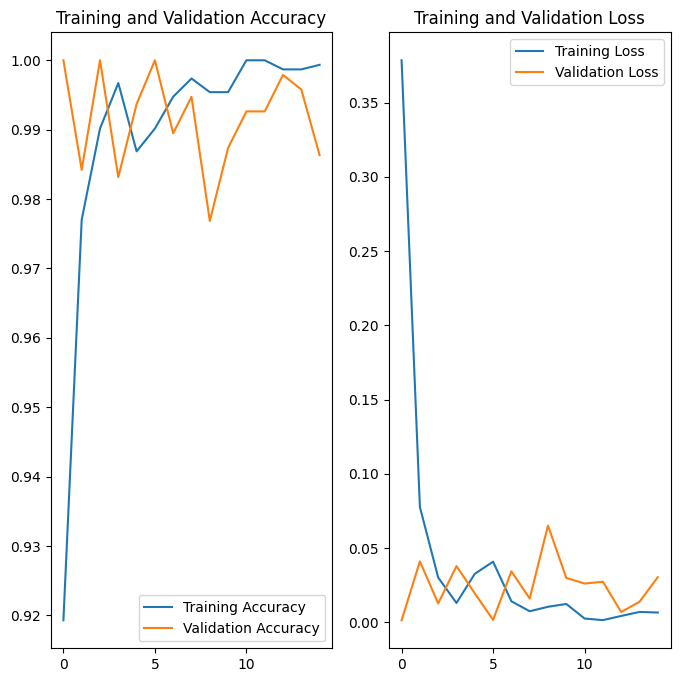

In [154]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [155]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras import layers

# Définir la partie commune du réseau de neurones
input_shape = (200, 200, 3)  # Définissez la forme d'entrée selon vos données
shared_model = Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu')
])

# Créer les deux branches pour les modèles individuels
input_1 = Input(shape=input_shape)
input_2 = Input(shape=input_shape)

# Première branche du modèle
model_1 = shared_model(input_1)
output_1 = Dense(num_classes, activation='softmax')(model_1)
model_1 = Model(inputs=input_1, outputs=output_1)

# Deuxième branche du modèle
model_2 = shared_model(input_2)
output_2 = Dense(num_classes, activation='softmax')(model_2)
model_2 = Model(inputs=input_2, outputs=output_2)

# Compiler les deux modèles
model_1.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

model_2.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

# Entraîner les deux modèles avec leurs propres données
epochs = 15
history_1 = model_1.fit(train_ds, validation_data=val_ds, epochs=epochs)
history_2 = model_2.fit(train_ds, validation_data=val_ds, epochs=epochs)

# Comparez les performances des deux modèles
accuracy_1 = history_1.history['val_accuracy']
accuracy_2 = history_2.history['val_accuracy']

print("Accuracy of Model 1:", accuracy_1)
print("Accuracy of Model 2:", accuracy_2)


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


48/48 [==============================] - 3s 41ms/step - loss: 28.5574 - accuracy: 0.8615 - val_loss: 0.2477 - val_accuracy: 0.9779
Epoch 2/15
48/48 [==============================] - 2s 36ms/step - loss: 0.0365 - accuracy: 0.9921 - val_loss: 0.2569 - val_accuracy: 0.9663
Epoch 3/15
48/48 [==============================] - 2s 36ms/step - loss: 0.0059 - accuracy: 0.9967 - val_loss: 0.1324 - val_accuracy: 0.9937
Epoch 4/15
48/48 [==============================] - 2s 36ms/step - loss: 0.0048 - accuracy: 0.9993 - val_loss: 0.1173 - val_accuracy: 0.9968
Epoch 5/15
48/48 [==============================] - 2s 44ms/step - loss: 1.2172e-04 - accuracy: 1.0000 - val_loss: 0.0952 - val_accuracy: 0.9989
Epoch 6/15
48/48 [==============================] - 2s 43ms/step - loss: 2.7585e-05 - accuracy: 1.0000 - val_loss: 0.0850 - val_accuracy: 0.9989
Epoch 7/15
48/48 [==============================] - 2s 37ms/step - loss: 2.0320e-05 - accuracy: 1.0000 - val_loss: 0.0831 - val_accuracy: 0.9989
Epoch 8/15


In [156]:
model_2.evaluate(val_ds)

30/30 [==============================] - 0s 10ms/step - loss: 0.4440 - accuracy: 0.9042


[0.44399499893188477, 0.9042105078697205]

In [157]:
model_1.evaluate(val_ds)

30/30 [==============================] - 0s 10ms/step - loss: 9.6589 - accuracy: 0.1147


[9.658865928649902, 0.11473684012889862]

## Predict on new data

Note: Data augmentation and dropout layers are inactive at inference time.

In [ ]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

file_to_predict = files.upload()

for file_ in file_to_predict:
    # Load the image as a PIL Image object
    image_to_predict = tf.keras.utils.load_img(
        file_, target_size=(img_height, img_width)
    )

    image_display = cv2.imread(file_, cv2.IMREAD_COLOR)
    plt.imshow(cv2.cvtColor(image_display, cv2.COLOR_BGR2RGB))
    plt.show()

    # Convert the PIL Image object to a NumPy array
    img_array = tf.keras.utils.img_to_array(image_to_predict)

    # Add a batch dimension
    img_array = tf.expand_dims(img_array, 0)

    # Make predictions
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "Cette image appartient a la classe {} with a {:.2f} pourcent."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

Conversion en TanserflowLite

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

### Run the TensorFlow Lite model

You can access the TensorFlow Lite saved model signatures in Python via the `tf.lite.Interpreter` class.

Load the model with the `Interpreter`:

In [ ]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [ ]:
interpreter.get_signature_list()

In [ ]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

Mettre a jour sequential_XXXX_input ci dessous

In [ ]:
predictions_lite = classify_lite(sequential_8_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [ ]:
print(
        "Cette image appartient a la classe {} with a {:.2f} pourcent."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

The prediction generated by the lite model should be almost identical to the predictions generated by the original model:

In [ ]:
print(np.max(np.abs(predictions - predictions_lite)))

Weight Sharing

In [ ]:
_, baseline_model_accuracy = model.evaluate(val_ds)

print('Baseline test accuracy:', baseline_model_accuracy)

_, keras_file = tempfile.mkstemp('.h5')
print('Saving model to: ', keras_file)
tf.keras.models.save_model(model, keras_file, include_optimizer=False)

In [ ]:
import tensorflow_model_optimization as tfmot

cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

clustering_params = {
  'number_of_clusters': 16,
  'cluster_centroids_init': CentroidInitialization.LINEAR
}

# Cluster a whole model
clustered_model = cluster_weights(model, **clustering_params)

# Use smaller learning rate for fine-tuning clustered model
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

clustered_model.compile(
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer=opt,
  metrics=['accuracy'])

clustered_model.summary()

In [ ]:
# Fine-tune model
clustered_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
clustered_model.evaluate(val_ds)

Both strip_clustering and applying a standard compression algorithm (e.g. via gzip) are necessary to see the compression benefits of clustering.

First, create a compressible model for TensorFlow. Here, strip_clustering removes all variables (e.g. tf.Variable for storing the cluster centroids and the indices) that clustering only needs during training, which would otherwise add to model size during inference.

In [ ]:
import tempfile

final_model = tfmot.clustering.keras.strip_clustering(clustered_model)

_, clustered_keras_file = tempfile.mkstemp('.h5')
print('Saving clustered model to: ', clustered_keras_file)
tf.keras.models.save_model(final_model, clustered_keras_file,
                           include_optimizer=False)

In [ ]:
clustered_tflite_file = '/tmp/clustered.tflite'
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
tflite_clustered_model = converter.convert()
with open(clustered_tflite_file, 'wb') as f:
  f.write(tflite_clustered_model)
print('Saved clustered TFLite model to:', clustered_tflite_file)

In [ ]:
def get_gzipped_model_size(file):
  # It returns the size of the gzipped model in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

In [ ]:
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped clustered Keras model: %.2f bytes" % (get_gzipped_model_size(clustered_keras_file)))
print("Size of gzipped clustered TFlite model: %.2f bytes" % (get_gzipped_model_size(clustered_tflite_file)))